# Preprocesamiento: escalamiento de *features*

Este notebook es una adaptación del [original de *Aurélien Gerón*](https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb), de su libro: [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition. Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/)

## Pasos previos

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

housing = pd.read_csv("./data/housing.csv") 

# Generación de conjuntos de entrenamiento y prueba mediante muestreo estratificado por ingreso medio
train_set, test_set = train_test_split(housing, test_size=0.2,
    stratify=pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5]),
    random_state=42
    )

housing = train_set.drop("median_house_value", axis=1) # Eliminamos la columna de la variable dependiente
housing_labels = train_set["median_house_value"].copy() # Guardamos la variable dependiente (etiquetas)

## Escalado, normalización y estandarización

La mayoría de los algoritmos de *Machine Learning* no funcionan bien cuando las *features* tienen escalas muy diferentes. Por ejemplo, muchos **clasificadores** calculan la distancia entre dos puntos mediante la distancia euclidiana. Si una de las características tiene valores mucho más grandes que las demás, la distancia se verá dominada por esta característica. Por ejemplo, en nuestro *dataset*, el rango de 'median_income' va de 0 a 15, mientras que el rango de 'total_rooms' va de 6 a 39.320.

Para evitarlo, es habitual escalar las *features*.

La terminología puede ser confusa en este punto. En general, la **normalización** se refiere a cambiar la escala de los datos para que se ajusten a un rango específico, mientras que la **estandarización** se refiere a cambiar la distribución de los datos para que tengan una media de 0 y una desviación estándar de 1. En ambos casos, se trata de transformaciones lineales que no cambian la forma de la distribución de los datos. En estadística suele haber una distinción clara entre ambos términos, pero en el aprendizaje profundo y en la visión por computadora, la terminología puede ser menos consistente y es habitual que se use "normalización" para referirse a la estandarización.

<!-- TODO: https://en.wikipedia.org/wiki/Normalization_(machine_learning) -->

In [17]:
housing.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,16512.0,-119.575635,2.001828,-124.3500,-121.80000,-118.51000,-118.010000,-114.3100
latitude,16512.0,35.639314,2.137963,32.5400,33.94000,34.26000,37.720000,41.9500
housing_median_age,16512.0,28.653404,12.574819,1.0000,18.00000,29.00000,37.000000,52.0000
total_rooms,16512.0,2622.539789,2138.417080,6.0000,1443.00000,2119.00000,3141.000000,39320.0000
total_bedrooms,16354.0,534.914639,412.665649,2.0000,295.00000,433.00000,644.000000,6210.0000
population,16512.0,1419.687379,1115.663036,3.0000,784.00000,1164.00000,1719.000000,35682.0000
households,16512.0,497.011810,375.696156,2.0000,279.00000,408.00000,602.000000,5358.0000
median_income,16512.0,3.875884,1.904931,0.4999,2.56695,3.54155,4.745325,15.0001


## MinMaxScaler

La normalización más común es la **normalización min-max** o ***min-max scaling***. La **normalización min-max** es la más sencilla: los valores se escalan y desplazan de forma que terminen en el rango entre un valor mínimo y un valor máximo. Normalmente será entre 0 y 1, aunque pueden ser otros (las redes neuronales suelen funcionar mejor con *inputs* con media 0, por lo que a veces se usa el rango -1 a 1). Scikit-Learn proporciona una clase `MinMaxScaler` para esto.

$$ X_{norm} = \frac{X - X_{min}}{X_{max} - X_{min}} $$

In [18]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

La normalización Min-Max es muy sensible a los *outliers*, ya que único valor muy grande puede cambiar completamente la escala de los datos. En una situación donde todos los datos están entre 20 y 30 pero aparece un único valor de 100, el máximo pasa a 100, desplazando todos los demás valores a un rango muy bajo. En general, la normalización Min-Max se debe usar solo si estamos seguros de que los *outliers* no son errores.

## StandardScaler

Por su parte, la **estandarización Z-score** (***standard score***) es diferente: primero resta la media (para que ésta sea 0), y luego divide por la **desviación típica (*standard deviation*)** para que la distribución resultante tenga desviación estándar 1. A diferencia del escalado min-max, la estandarización no limita los valores entre un rango concreto, pero esto tiene también la ventaja de ser mucho menos sensible a los valores atípicos. Scikit-Learn proporciona una clase `StandardScaler` para esto.

$$ X_{std} = \frac{X - \mu}{\sigma} $$

In [19]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

Muchos modelos de ML funcionan mejor estandarizando las *features* de entrada y es una práctica habitual y sistemática en la mayoría de los casos (salvo para modelos basados en árboles). Escalar el *target* es menos común, pero puede ser útil en algunos casos, particularmente para modelos basados en gradientes (como las redes neuronales) o modelos basados en distancias (como regresiones KNN o SVM).

Por ejemplo, podríamos aplicar de nuevo StandardScarler a las etiquetas:

In [20]:
target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame()) # convertimos el target a un dataframe (fit_transform espera 2D)
print(type(housing_labels)) # Al ser una única columna, las etiquetas fueron almacenadas antes en un objeto Series
scaled_labels

<class 'pandas.core.series.Series'>


array([[-1.16601465],
       [ 0.62745084],
       [-1.07439665],
       ...,
       [-0.5756836 ],
       [ 0.44162188],
       [-1.2472608 ]])

## Escalado de variables objetivo y posterior inversión

Si transformamos de cualquier manera la variable objetivo, la salida de nuestro modelo también devolverá predicciones transformadas. Si queremos que las predicciones estén en la escala original, necesitaremos invertir la transformación. Muchos de los transformadores de Scikit-Learn tienen un método `inverse_transform()`, lo que facilita calcular la inversa de sus transformaciones.
<!-- TODO: Los transformadores categóricos no lo tienen ya que entonces estaríamos en un problema de clasificación. // No todos son invertibles? -->

Por poner un ejemplo simplificado, vamos a entrenar una **regresión lineal simple con el predictor que más correla** (median_income) y las etiquetas que acabamos de escalar. Seguidamente vamos a probar sus predicciones con el conjunto de test y deshacer la transformación.

In [21]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels) # entrenamos el modelo con las variables independientes escaladas

some_new_data = housing[["median_income"]].iloc[:5]  # por simplicidad, simulamos nuevos inputs para predecir tomando 5 filas (no hemos preprocesado el conjunto de test)

scaled_predictions = model.predict(some_new_data)
target_scaler.inverse_transform(scaled_predictions) # Deshacemos la transformación para obtener las predicciones en la escala original

array([[135958.75805364],
       [309735.008975  ],
       [165232.3998617 ],
       [138162.41971241],
       [232903.1766333 ]])

Este proceso se puede simplificar utilizando la clase `TransformedTargetRegressor` de Scikit-Learn, que permite entrenar un modelo con las etiquetas transformadas y deshacer la transformación automáticamente.    

In [22]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(regressor = LinearRegression(),
                                   transformer = StandardScaler()) # transformador de la variable dependiente
model.fit(housing[["median_income"]], housing_labels)
model.predict(some_new_data)

array([135958.75805364, 309735.008975  , 165232.3998617 , 138162.41971241,
       232903.1766333 ])

## Distribuciones de cola pesada

Las distribuciones de cola pesada se caracterizan por una cola larga hacia alguno de los lados, lo que significa que contienen algunos valores muy grandes que pueden influir desproporcionadamente en el modelo. La transformación logarítmica comprime esta cola larga, reduciendo el rango de valores y haciendo que la distribución sea más normal. Esto ayuda a disminuir el impacto de los valores atípicos, lo que conduce a modelos más estables y robustos. Después de aplicar el logaritmo, el escalado sigue siendo importante para llevar los datos transformados a un rango común, asegurando que todas las características contribuyan por igual al proceso de aprendizaje y mejorando aún más el rendimiento del modelo.

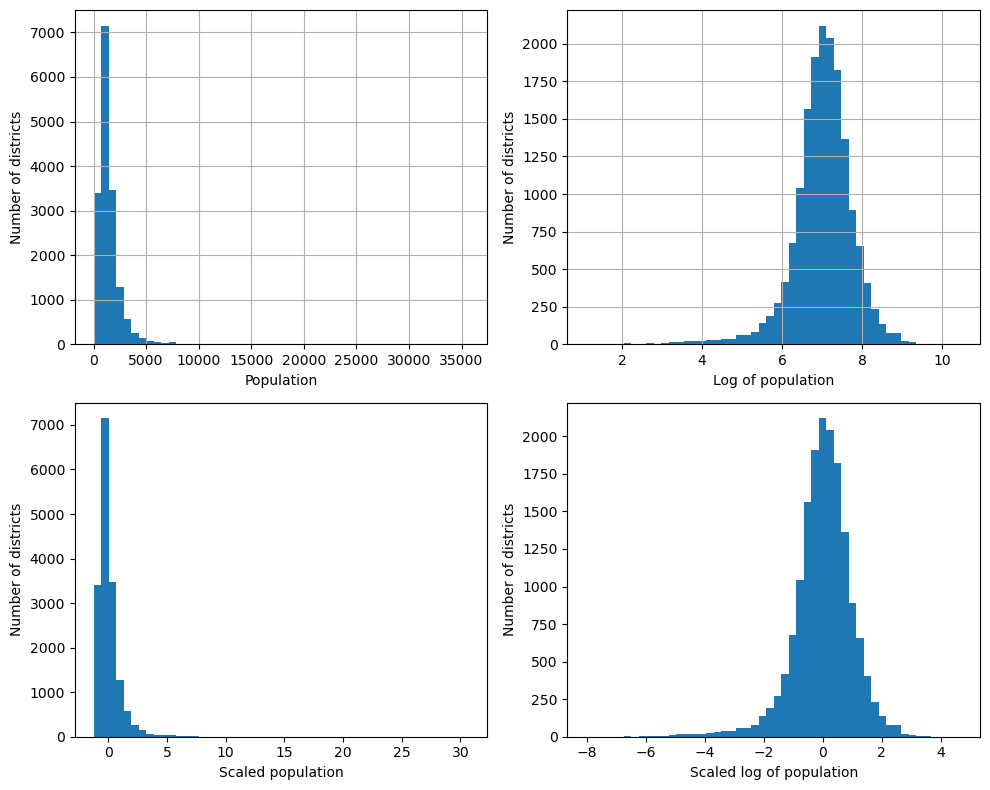

In [23]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Original distribution
housing["population"].hist(ax=axs[0, 0], bins=50)
axs[0, 0].set_xlabel("Population")
axs[0, 0].set_ylabel("Number of districts")

# Log transformation
log_pop = housing["population"].apply(np.log)
log_pop.hist(ax=axs[0, 1], bins=50)
axs[0, 1].set_xlabel("Log of population")
axs[0, 1].set_ylabel("Number of districts")

# Standard scaling
scaler = StandardScaler()
scaled_pop = scaler.fit_transform(housing["population"].values.reshape(-1, 1)).flatten()
axs[1, 0].hist(scaled_pop, bins=50)
axs[1, 0].set_xlabel("Scaled population")
axs[1, 0].set_ylabel("Number of districts")

# Log transformation + standard scaling
scaled_log_pop = scaler.fit_transform(log_pop.values.reshape(-1, 1)).flatten()
axs[1, 1].hist(scaled_log_pop, bins=50)
axs[1, 1].set_xlabel("Scaled log of population")
axs[1, 1].set_ylabel("Number of districts")

plt.tight_layout()
plt.show()